<h2>BMIF201 Lecture 1 in-class problem set instructions</h2>

This ungraded in-class problemset is intended to be completed in assigned groups of 2-3 in class. All members of each group should type their own solutions, but the solutions can be exactly identical. Feel free to ask other groups, the TAs, or the professor for assistance. Your homework for this unit will build upon the work that you do in these worksheets, so please make sure you complete them. 

None of the questions should require computations that take more than a few seconds, although it's OK if they take longer. If you find yourself waiting for a solution  to run, try using smaller simulation parameters.

You will implement the Wright-Fisher model and verify several of the results that we learned today in lecture. First, open wright_fisher.py in your text editor, familiarize yourself with the code that has been written, and find the item marked TODO. One you've implemented it, you should be able to run the following two blocks without error.


In [1]:
import numpy as np

class WrightFisher:
    mutation_rate: float
    population_size: int

    # This is the function that is called when you write: model = WrightFisher(...)
    def __init__(self, mutation_rate: float, population_size: int):
        self.mutation_rate = mutation_rate
        self.population_size = population_size

    def next_generation(self, allele_frequencies: np.ndarray) -> np.ndarray:
        """
        :param allele_frequencies: array of allele frequencies in generation n
        :return: array of allele frequencies in generation n+1
        """

        expected_frequency = allele_frequencies.copy()  # avoid modifying input array

        # Effect of mutation
        expected_frequency = (expected_frequency * (1 - self.mutation_rate) +
                              (1 - expected_frequency) * self.mutation_rate)


        # Effect of drift
        binomial_samples = np.random.binomial(2 * self.population_size, expected_frequency)

        return binomial_samples / (2 * self.population_size)

    def until_fixation(self, initial_allele_frequencies: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        :param initial_allele_frequencies: initial state
        :return: final allele frequencies (0/1-valued), time to fixation or loss
        """

        allele_frequencies = initial_allele_frequencies.copy()  # avoids modifying input array
        variants = np.where(allele_frequencies * (1-allele_frequencies) > 0)[0]  # sites not yet fixed or lost
        time_to_fixation_or_loss = np.zeros_like(allele_frequencies, dtype=int)

        generations = 0
        while len(variants) > 0:
            generations += 1
            allele_frequencies[variants] = self.next_generation(allele_frequencies[variants])
            newly_fixed_variants = (allele_frequencies[variants] * (1-allele_frequencies[variants]) == 0)
            time_to_fixation_or_loss[variants[newly_fixed_variants]] = generations
            variants = variants[~newly_fixed_variants]

        assert np.all(allele_frequencies * (1-allele_frequencies) == 0)

        return allele_frequencies, time_to_fixation_or_loss


In [2]:
num_sites = 5
mutation_rate = 1e-1
population_size = 100
model = WrightFisher(mutation_rate, population_size)
generation_zero_frequency = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) 

np.random.seed(123)
generation_one_frequency = model.next_generation(generation_zero_frequency)
assert np.all(generation_one_frequency == np.array([0.195, 0.255, 0.375, 0.415, 0.55]))

<h5> Problem 1 </h5>

Recall that the variance of the $Binomial(n,p)$ distribution is $np(1-p)$. What is the variance of $p_{t+1}$ given $p_t$?

In [3]:
def variance_in_frequency_per_generation(starting_frequency, population_size):
    #TODO
    return starting_frequency * (1 - starting_frequency) / (2 * population_size)

assert np.isclose(variance_in_frequency_per_generation(0.2, 100), 0.0008)

Verify that in your simulations, the sample variance agrees with what you calculated above.

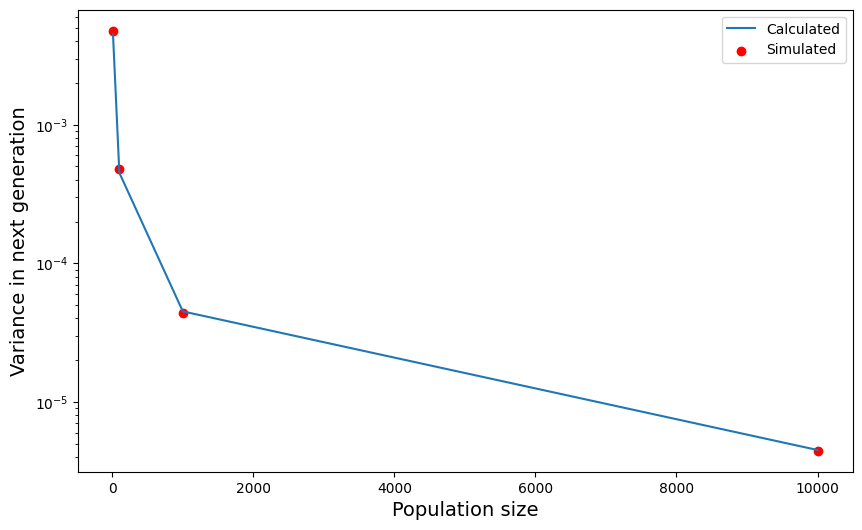

In [13]:
num_sites = 1000
mutation_rate = 0.001
population_size = [10, 100, 1000, 10_000]
starting_frequency = 0.1
simulated_variance = []
calculated_variance = []
for N in population_size:
    model = WrightFisher(mutation_rate, N)
    frequency = model.next_generation(starting_frequency * np.ones(num_sites))
    simulated_variance.append(np.var(frequency))
    calculated_variance.append(variance_in_frequency_per_generation(starting_frequency, N))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(population_size, calculated_variance)
plt.scatter(population_size, simulated_variance, color='red')
plt.yscale('log')
plt.legend(["Calculated", "Simulated"])
# plt.xscale('log')

plt.xlabel('Population size', fontsize=14)
plt.ylabel('Variance in next generation', fontsize=14)

plt.show()

<h5> Problem 2 </h5>

Recall that the probability of fixation for a neutral allele with starting frequency $p$ is $u(p)=p$. Using the function WrightFisher.until_fixation, verify this for the provided values of $N$ and $p$ by plotting $u(p)$ vs. $p$. 

In [14]:
num_sites = 1_000
mutation_rate = 0
population_size = 100
starting_frequency = np.arange(1,10) / 10
simulated_fixation_probability = []

model = WrightFisher(mutation_rate, population_size)
for p in starting_frequency:
    allele_frequencies = p * np.ones(num_sites)
    allele_frequencies, _ = model.until_fixation(allele_frequencies)
    simulated_fixation_probability.append(np.mean(allele_frequencies))


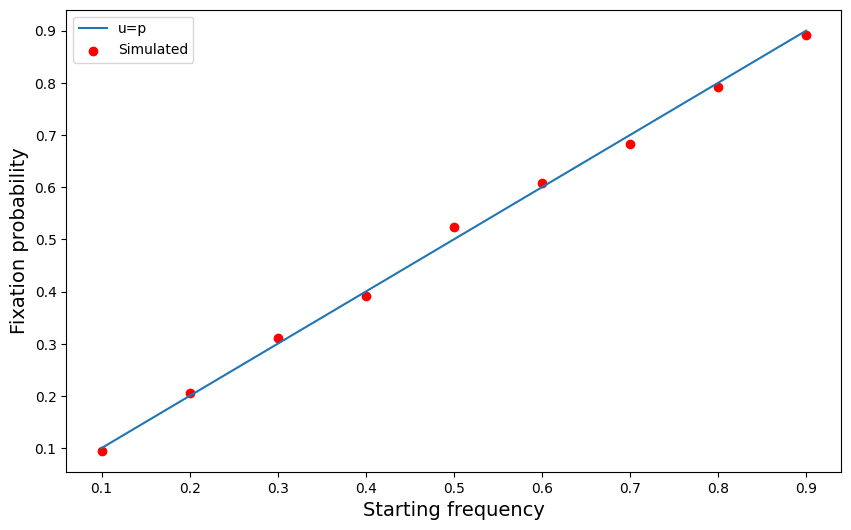

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(starting_frequency, starting_frequency)
plt.scatter(starting_frequency, simulated_fixation_probability, color="red")
plt.legend(["u=p", "Simulated"])

plt.xlabel('Starting frequency', fontsize=14)
plt.ylabel('Fixation probability', fontsize=14)
plt.show()

Recall that the time to fixation or for a rare allele is approximately $4N$ generations. Verify this for the parameters below, and plot a histogram of the fixation time. 



In [17]:
num_sites = 100_000
mutation_rate = 0
population_size = 100
starting_frequency = 1 / (2 * population_size)

model = WrightFisher(mutation_rate, population_size)
allele_frequencies, stopping_times = model.until_fixation(starting_frequency * np.ones(num_sites))
fixation_times = stopping_times[allele_frequencies == 1]

print(f"Number of fixed sites: {np.sum(allele_frequencies)}")
print(f"Mean fixation time: {np.mean(fixation_times)}")

Number of fixed sites: 478.0
Mean fixation time: 395.8075313807531


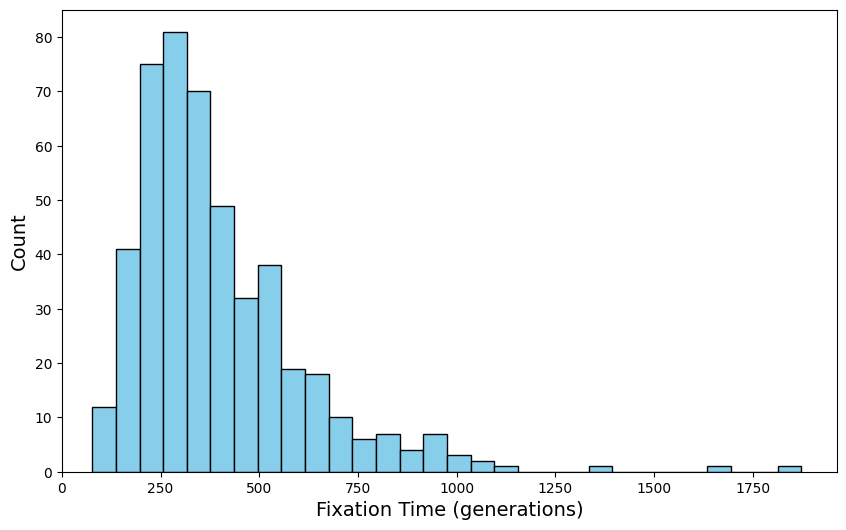

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(fixation_times, bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Fixation Time (generations)', fontsize=14)
plt.xlim(left=0)
plt.ylabel('Count', fontsize=14)

plt.show()

<h5> Problem 3 </h5>

In lecture we derived the mean heterozygosity at equilibrium:
$$E(2p(1-p))\approx 4N\mu$$
Show that with a population size of 100, the approximation is good for small $\mu$. Find the approximate value of $\mu$ at which the approximation breaks down.

In [19]:
num_sites = 1_000
population_size = 100
mutation_rate = np.array([0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 1, 10]) / population_size
starting_frequency = 1 / population_size
frequency = starting_frequency * np.ones(num_sites)
mean_heterozygosity = []
for mu in mutation_rate:
    model = WrightFisher(mu, population_size)
    for generations in range(10*population_size):
        frequency = model.next_generation(frequency)
    mean_heterozygosity.append(2 * np.mean(frequency * (1-frequency)))

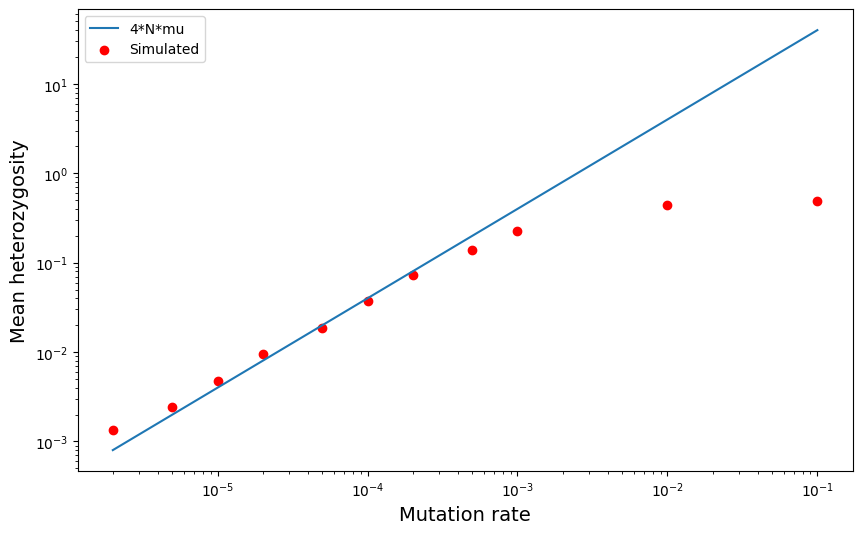

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
theta = 4 * np.asarray(mutation_rate) * population_size
plt.plot(mutation_rate, theta)
# plt.plot(mutation_rate, theta / (1 + 2 * theta))
plt.scatter(mutation_rate, mean_heterozygosity, color="red")
plt.legend(["4*N*mu", "Simulated"])
# plt.legend(["4*N*mu / (1 + 8 * N * mu)", "Simulated"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Mutation rate', fontsize=14)
plt.ylabel('Mean heterozygosity', fontsize=14)
plt.show()

<h5> Problem 4 </h5>

Recall that in population at mutation-drift balance, the site frequency spectrum (SFS) of polymorphic sites is:
$$E(s_k)\propto 1/k$$
where $s_k$ is the number of variants with allele count equal to $k$. Confirm this in simulations by plotting the SFS after a large enough number of generations that equilibrium has been reached. A plotting script has been provided for you. 

In [22]:
num_sites = 100_000
population_size = 100
mutation_rate = 0.00001 # positive number << 1 / population_size
starting_frequency = 1 / population_size
num_generations = 1000 # >> population_size
model = WrightFisher(mutation_rate, population_size)

allele_frequencies = starting_frequency * np.ones(num_sites)
for i in range(num_generations):
    allele_frequencies = model.next_generation(allele_frequencies)


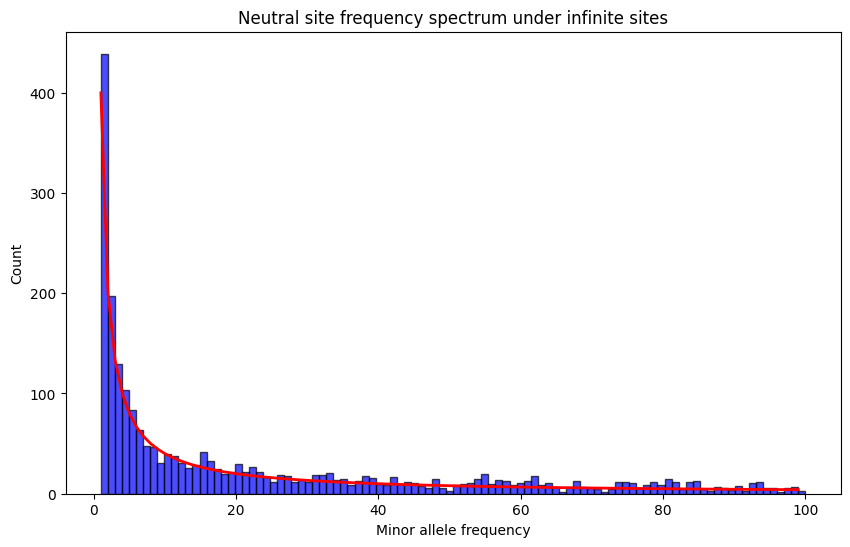

In [23]:
# Histogram of minor allele counts
minor_allele_frequency = np.minimum(allele_frequencies, 1-allele_frequencies)
minor_allele_count_positive = minor_allele_frequency[minor_allele_frequency > 0] * 2 * population_size
plt.figure(figsize=(10, 6))
plt.hist(minor_allele_count_positive, bins=population_size, alpha=0.7, color='blue', edgecolor='black')
 
# Plot y = 1/x
x = np.arange(1,population_size)
y = 4 * population_size * mutation_rate * num_sites / x
plt.plot(x, y, color='red', label='y = 1/x', linewidth=2)

plt.title('Neutral site frequency spectrum under infinite sites')
plt.ylabel('Count')
plt.xlabel('Minor allele frequency')

plt.show()

<h5> Problem 5 </h5>

The number of segregating sites in a population is the number of sites at which any two individuals differ. In a large population, the number of segregating sites grows, and most are rare. Calculate the mean heterozygosity *of segregating sites*, $E(p(1-p)|0<p<1)$, in a population of size $N\in \{10, 100, 1000, 10000\}$, with $0 < \mu << 1/N$. Compare with the mean heterozygosity across all sites. Discuss with your partner: if the mean heterozygosity increases with $N$, why does the mean heterozygosity of segregating sites decrease? (Hint: see optional Problem 6 below).


In [24]:
num_sites = 10_000
mutation_rate = 0.0001 # positive number << 1 / population_size
population_size_array = [10, 100, 1000, 10_000]
mean_heterozygosity_segregating_sites = {}
for population_size in population_size_array:
    starting_frequency = 1 / population_size
    num_generations = 1000
    model = WrightFisher(mutation_rate, population_size)
    
    allele_frequencies = starting_frequency * np.ones(num_sites)
    for i in range(num_generations):
        allele_frequencies = model.next_generation(allele_frequencies)
    heterozygosity = 2 * allele_frequencies * (1-allele_frequencies)
    mean_heterozygosity_segregating_sites[population_size] = np.mean(heterozygosity[heterozygosity > 0])
print(mean_heterozygosity_segregating_sites)

{10: np.float64(0.23020000000000002), 100: np.float64(0.1780640529050543), 1000: np.float64(0.14194324284626264), 10000: np.float64(0.16113671675650001)}


<h3>Optional problems</h3>

If you finish the problems above early, please work on the following problems with your partner. These are discussion questions, so there is no need to write down your solution; but of course, feel free to use simulations.

<h5>Problem 6</h5>

Discuss with your partner: suppose that in a population of size $N$, with $\mu<<1/N$, you sample $S<N$ haplotypes without replacement and calculate the mean heterozygosity. Will it depend upon $N$, upon $S$, or both? 

<h5>Problem 7</h5>

Discuss with your partner: as the study size $S$ increases, approximately how many segregating sites in total will be observed? What fraction of sites will be singletons? Do these quantities depend on $N$?

<h5>Problem 8</h5>

Next week, we will learn about *demography*, or population history. An important feature of human demography is a rapid increase in population size, over multiple time scales. Discuss with your partner: qualitatively, what influence does recent population expansion have on the SFS? (Hint: with constant population size, what is the average number of alleles that are fixed/lost per generation?)